<a href="https://colab.research.google.com/github/pakdaniel/DataMiningFinal/blob/main/DataMiningFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%%capture
!pip install vit-pytorch
!pip install datasets
!pip install transformers

In [3]:
# import tensorflow as tf
import numpy as np 
import math
import random
import matplotlib.pyplot as plt
import os 
import sys
import librosa
import librosa.display
from warnings import warn
from IPython.display import Audio, display
from scipy import signal 
from scipy.io import wavfile
from collections import Counter
import time

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torchaudio
from torchaudio import transforms
from vit_pytorch import ViT

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

COLAB = False

In [4]:
if COLAB:
    from google.colab import drive
    drive_root = '/content/drive'
    drive.mount(drive_root)
    VIVAE_PATH = os.path.join(drive_root, "My Drive", "VIVAE", "full_set")
else:
    VIVAE_PATH = os.path.join("../VIVAE", "full_set")
    
audio_paths = [os.path.join(VIVAE_PATH, i) for i in os.listdir(VIVAE_PATH)]
audio_paths.sort()

# Previous Audio Class Using numpy and librosa

In [ ]:
class Audio():
  def __init__(self, audio, sr, file_name):
    self.audio = audio
    self.N = len(audio)
    self.sr = sr 
    self.file_name = file_name
    self.labels()

  def labels(self):
    metadata = self.file_name.split("/")[-1].split("_")
    self.subject = metadata[0]
    self.emotion_label = metadata[1] 
    self.emotion_intensity = metadata[2]
    self.emotion = metadata[1] + "_" + metadata[2]

  def plot_time_series(self):
    t = np.arange(self.N)/self.sr
    plt.figure(figsize=(8,6))
    plt.plot(t, self.audio)
    plt.xlabel("Time (s)", fontsize=12)
    plt.title("Time Series", fontsize=12)
    plt.show()

  def spectrogram(self, hop_length=64, n_fft=1024):
    spec = np.abs(librosa.stft(self.audio, hop_length=hop_length, n_fft = n_fft))
    spec = librosa.amplitude_to_db(spec, ref=np.max) 
    return spec

  def plot_spectrogram(self, hop_length=64, n_fft=1024):
    spec = self.spectrogram(hop_length, n_fft)
    plt.figure(figsize=(8,6));
    librosa.display.specshow(spec, sr=self.sr, hop_length=hop_length, x_axis='time', y_axis='linear');
    plt.colorbar(format='%+2.0f dB');
    plt.title('Spectrogram', fontsize=12);

  def mel_spectrogram(self, hop_length=64, n_fft=1024, n_mels=64):
    mel_spec = librosa.feature.melspectrogram(self.audio, sr=self.sr, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec

  def plot_mel_spectrogram(self, hop_length=64, n_fft=1024, n_mels=64):
    spec = self.mel_spectrogram(hop_length, n_fft, n_mels)
    plt.figure(figsize=(8,6))
    librosa.display.specshow(spec, sr=self.sr, hop_length=hop_length, x_axis='time', y_axis='mel');
    plt.colorbar(format='%+2.0f dB');
    plt.title('Mel Spectrogram', fontsize=12);

# plt.figure(figsize=(8,6))
# plt.title('Spectrogram')    
# Pxx, freqs, bins, im = plt.specgram(y,Fs=fs,NFFT=256)

# print(Pxx.shape)
# print(freqs.shape)
# print(bins.shape)

# plt.xlabel('Time')
# plt.ylabel('Frequency')

In [ ]:
audio_all = []
i = 0
for audio_path in audio_paths:
  i = i+1
  data, sr = librosa.load(audio_path, sr=None) # by default it scales data between [-1, 1]
  # sr, data = wavfile.read(audio_path)
  audio_all.append(Audio(data, sr, audio_path))
  if i % 100 == 0:
    print(f"At {i}")

At 100
At 200
At 300
At 400
At 500
At 600
At 700
At 800
At 900
At 1000


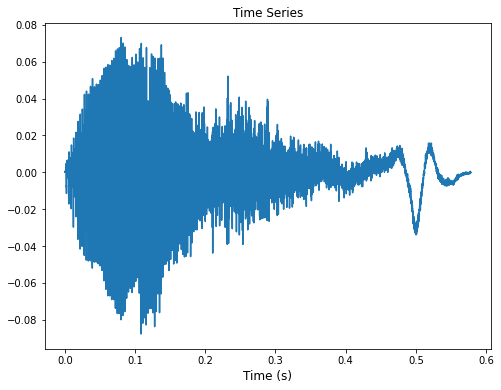

In [ ]:
audio_all[0].plot_time_series()

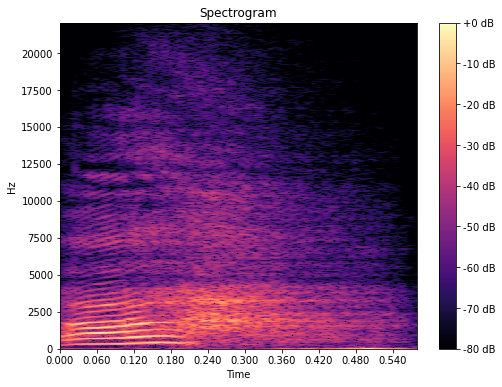

In [ ]:
audio_all[0].plot_spectrogram()

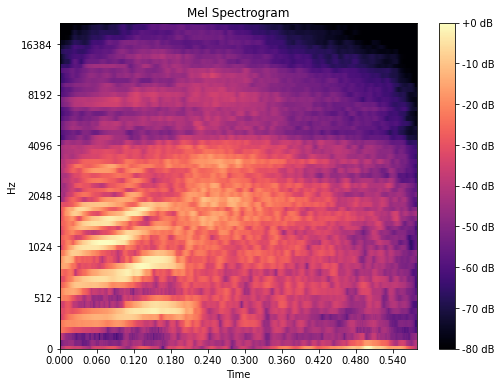

In [ ]:
audio_all[0].plot_mel_spectrogram()

In [ ]:
audio_all[0].mel_spectrogram().shape

(64, 399)

# Distribution of Labels

In [5]:
def all_labels(inp):
  emotion_type = []
  emotion_intensities = []
  emotion_labels = []

  for file_name in audio_paths:
    metadata = file_name.split("/")[-1].split("_")
    emotion_type.append(metadata[1]) 
    emotion_intensities.append(metadata[2])
    emotion_labels.append(metadata[1] + "_" + metadata[2])

  res = dict()

  if inp == "emotion_type":
    for i in emotion_type:
      if i not in res:
        res[i] = 1
      else:
        res[i] += 1
  elif inp == "emotion_intensity":
    for i in emotion_intensities:
      if i not in res:
        res[i] = 1
      else:
        res[i] += 1
  elif inp == "emotion_full_label":
    for i in emotion_labels:
      if i not in res:
        res[i] = 1
      else:
        res[i] += 1

  res = dict(sorted(res.items()))

  label_encoding = {}
  for count, val in enumerate(res):
    label_encoding[val] = count

  return label_encoding

LABEL_TYPE = "emotion_type"
LABEL_ENCODING = all_labels(LABEL_TYPE) 

LABEL_ENCODING

{'achievement': 0,
 'anger': 1,
 'fear': 2,
 'pain': 3,
 'pleasure': 4,
 'surprise': 5}

# Creating Audio Class Using torchaudio 

In [6]:
class Audio():
  def __init__(self, audio_file, label_type, label_mapping):
    self.audio_file = audio_file
    self.open()
    self.set_labels(label_type, label_mapping)

  def open(self):
    self.audio, self.sr = torchaudio.load(self.audio_file)

  def set_labels(self, label_type, label_mapping):
    metadata = self.audio_file.split("/")[-1].split("_")
    self.subject = metadata[0]
    if label_type == "emotion_type":
      self.label = metadata[1]
    elif label_type == "emotion_intensity":
      self.label = metadata[2]
    elif label_type == "emotion_full_label":
      self.label = metadata[1] + "_" + metadata[2]
    self.label_encoding = label_mapping[self.label]

  def get_audio(self):
    return self.audio

  def plot_time_series(self, audio):
    t = np.arange(audio.size()[1])/self.sr
    plt.figure(figsize=(8,6))
    plt.plot(t, audio.squeeze().detach().numpy())
    plt.xlabel("Time (s)", fontsize=12)
    plt.title("Time Series", fontsize=12)
    plt.show()

  def mel_spectrogram(self, audio, hop_length=64, n_fft=1024, n_mels=64, top_db=80):
    spec = transforms.MelSpectrogram(self.sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)(audio)
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return spec

  def plot_mel_spectrogram(self, audio, hop_length=64, n_fft=1024, n_mels=64, top_db=80):
    spec = self.mel_spectrogram(audio, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels, top_db=top_db).detach().squeeze().numpy()
    plt.figure(figsize=(8,6))
    librosa.display.specshow(spec, sr=self.sr, hop_length=hop_length, x_axis='time', y_axis='mel');
    plt.colorbar(format='%+2.0f dB');
    plt.title('Mel Spectrogram', fontsize=12);
  
  def get_mel_spectrogram_and_label(self, audio, n_mels):
    return self.mel_spectrogram(audio, n_mels=n_mels), self.label_encoding

  def get_time_series_and_label(self, audio):
    return audio.squeeze(), self.label_encoding

  def pad_time_series(self, audio, max_length):
    assert audio.dim() == 2, "Audio should be of dim 2"
    curr_len = audio.size()[1]

    # get beginning part of time series
    if curr_len > max_length:
      audio = audio[:,:max_length]
    
    # two sided padding
    elif curr_len < max_length:
      left = math.floor((max_length-curr_len)/2)
      right = (max_length-curr_len)-left
      audio = F.pad(audio, (left,right), "constant", 0)

    return audio  
  
  def resample(self, audio, sr, resample_sr):
    resampler = transforms.Resample(sr, resample_sr)
    resampled_audio = resampler(audio)
    return resampled_audio

torch.Size([1, 25507])


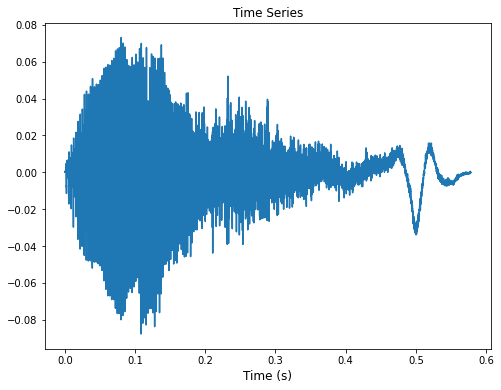

torch.Size([1, 30000])


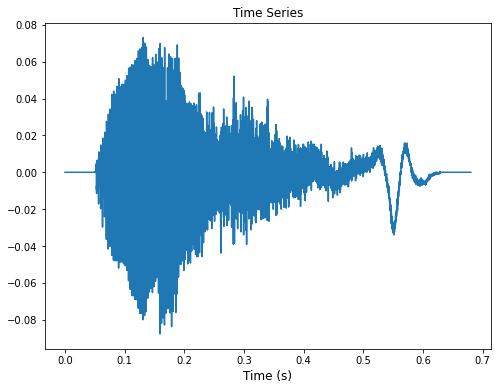

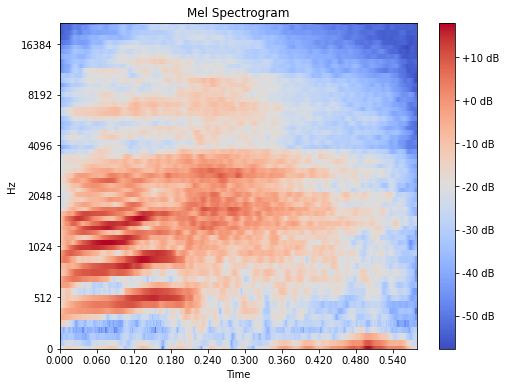

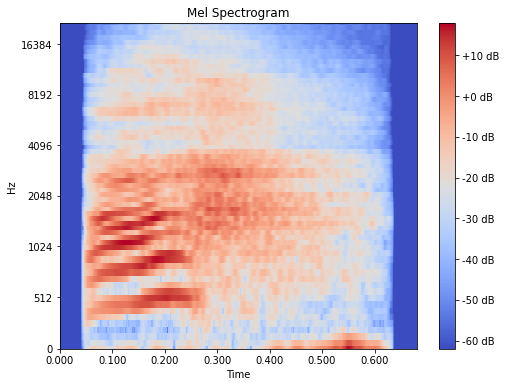

In [ ]:
test = Audio(audio_paths[0], LABEL_TYPE, LABEL_ENCODING)
aud = test.get_audio()
padded_aud = test.pad_time_series(aud, 30000)

print(aud.size())
test.plot_time_series(aud)

print(padded_aud.shape)
test.plot_time_series(padded_aud)

test.plot_mel_spectrogram(aud)
test.plot_mel_spectrogram(padded_aud)


In [ ]:
# def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
#   # https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
#   fig, axs = plt.subplots(1, 1)
#   axs.set_title(title or 'Spectrogram (db)')
#   axs.set_ylabel(ylabel)
#   axs.set_xlabel('frame')
#   im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
#   if xmax:
#     axs.set_xlim((0, xmax))
#   fig.colorbar(im, ax=axs)
#   plt.show(block=False)

torch.Size([1, 64, 430])
torch.Size([1, 64, 430])


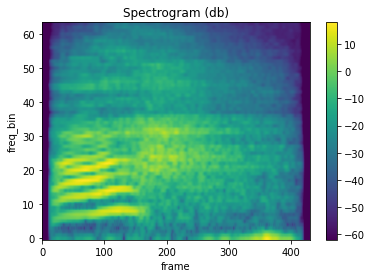

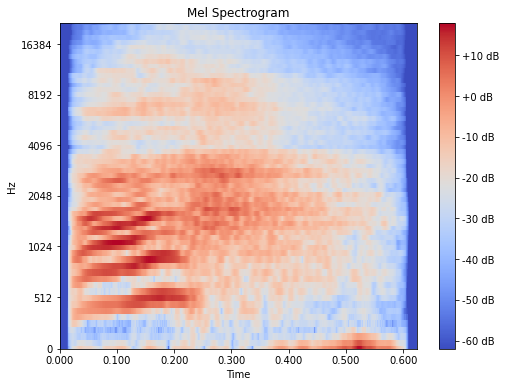

In [ ]:
n_fft = 1024
n_mels = 64
top_db = 80
hop_length = 64

melspec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, pad=1000)(audio)

print(melspec.size())


plot_spectrogram(melspec[0])

melspec = transforms.AmplitudeToDB(top_db = 80, stype = "power")(melspec)
# melspec = librosa.power_to_db(melspec[0].numpy(), ref=80)

plt.figure(figsize=(8,6))
librosa.display.specshow(melspec[0].numpy(), sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');
plt.title('Mel Spectrogram', fontsize=12);

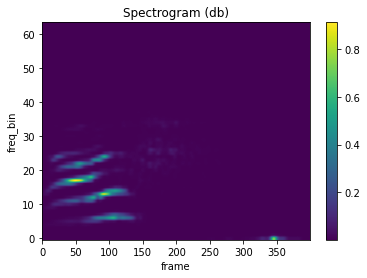

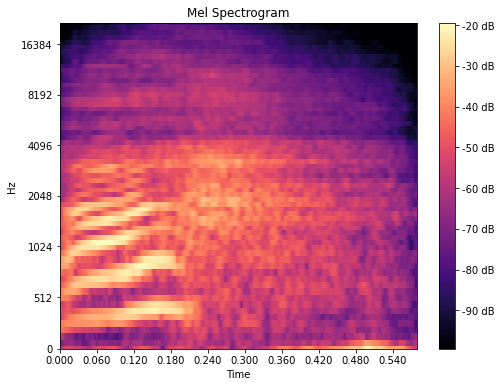

In [ ]:
melspec_librosa = librosa.feature.melspectrogram(
    audio.numpy()[0],
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    center=True,
    power=2.0,
    n_mels=n_mels,
)

plot_spectrogram(melspec_librosa)

melspec_librosa = librosa.power_to_db(melspec_librosa, ref=80)

plt.figure(figsize=(8,6))
librosa.display.specshow(melspec_librosa, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');
plt.title('Mel Spectrogram', fontsize=12);

# plot_spectrogram(
#     melspec_librosa, title="MelSpectrogram - librosa", ylabel='mel freq')

In [ ]:
mse = torch.square(melspec - melspec_librosa).mean().item()
print('Mean Square Difference: ', mse)

Mean Square Difference:  17.840179443359375


# Creating Dataset

In [ ]:
a = []
for count, i in enumerate(audio_paths):
  if count % 100 == 0:
    print(count)

  aud, sr = torchaudio.load(i)
  a.append(aud.size()[1])
print(np.mean(a))

0
100
200
300
400
500
600
700
800
900
1000
39819.2064516129


In [16]:
# Longest Audio Clip is 88200 samples
# max_length = 0

# for count, i in enumerate(audio_paths):
#   if count % 100 == 0:
#     print(count)

#   aud, sr = torchaudio.load(i)
#   if aud.size()[1] > max_length:
#     max_length = aud.size()[1]
#     j = i
# print(max_length)
# print(j)

# aud, _ = torchaudio.load("/content/drive/My Drive/VIVAE/full_set/S03_anger_moderate_01.wav")
aud, _ = torchaudio.load("../VIVAE/full_set/S03_anger_moderate_01.wav")
print(aud.size())

0
100
200
300
400
500
600
700
800
900
1000
88200
../VIVAE/full_set/S03_anger_moderate_01.wav
torch.Size([1, 88200])


In [17]:
class AudioDataset(Dataset):
  def __init__(self, audio_paths, label_type, label_mapping):
    super(AudioDataset, self).__init__()
    self.audio_paths = audio_paths
    self.label_type = label_type 
    self.label_mapping = label_mapping

  def __len__(self):
    return len(self.audio_paths)

  def __getitem__(self, idx):
      audio = Audio(self.audio_paths[idx], self.label_type, self.label_mapping)
      audio_padded = audio.pad_time_series(audio.get_audio(), 44100)
      return audio.get_mel_spectrogram_and_label(audio_padded, n_mels=64)


class AudioDatasetMLP(Dataset):
  def __init__(self, audio_paths, label_type, label_mapping, padding):
    super(AudioDatasetMLP, self).__init__()
    self.audio_paths = audio_paths
    self.label_type = label_type 
    self.label_mapping = label_mapping
    self.padding = padding

  def __len__(self):
    return len(self.audio_paths)

  def __getitem__(self, idx):
      audio = Audio(self.audio_paths[idx], self.label_type, self.label_mapping)
      audio_padded = audio.pad_time_series(audio.get_audio(), self.padding)
      return audio.get_time_series_and_label(audio_padded)

In [21]:
# dataset = AudioDataset(audio_paths, LABEL_TYPE, LABEL_ENCODING)
# loader = DataLoader(dataset, shuffle=1, batch_size=10)

# dataset[1084][0].shape

torch.Size([1, 64, 690])

# MLP

In [22]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, output_dim)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [23]:
padding = 44100

dataset = AudioDatasetMLP(audio_paths, LABEL_TYPE, LABEL_ENCODING, padding)
dataset_size = len(dataset)

split = 0.2 # Train-Test split is 80% 20%
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

batch_size = 30
train_loader = DataLoader(train_set, 
                          shuffle = True, 
                          batch_size = batch_size)
test_loader = DataLoader(test_set, 
                        shuffle = True, 
                        batch_size = batch_size)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(padding, 6).to(device)

learning_rate = 0.2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=5,  
                                            gamma=1)

In [26]:
EPOCHS = 100

train_losses = []
train_accs = []

test_losses = []
test_accs = []

print("MLP")
start = time.time()
for epoch in range(1, EPOCHS+1):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader):
        features, labels = data
        features = features.to(device)
        labels = labels.type(torch.LongTensor).to(device)
        predictions = model(features).squeeze()

        loss = criterion(predictions,labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        train_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    with torch.no_grad():
      test_loss = 0.0 
      test_acc = 0.0
      for i, data in enumerate(test_loader):
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)
        predictions = model(features)

        loss = criterion(predictions, labels)
        test_loss += loss.item()

        test_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc = 100*train_acc.item()/len(train_set)
    test_acc = 100*test_acc.item()/len(test_set)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch: {epoch} Train Loss: {round(train_loss,4)} Test Loss: {round(test_loss,4)} Train Acc: {round(train_acc,4)}% Test Acc: {round(test_acc,4)}%")
    
print(f"Done training after {time.time()-start} seconds")

MLP
Epoch: 1 Train Loss: 52.2591 Test Loss: 14.4137 Train Acc: 16.129% Test Acc: 17.5115%
Epoch: 2 Train Loss: 52.3474 Test Loss: 14.4733 Train Acc: 15.0922% Test Acc: 19.3548%
Epoch: 3 Train Loss: 52.5849 Test Loss: 14.5902 Train Acc: 17.6267% Test Acc: 13.8249%
Epoch: 4 Train Loss: 52.0838 Test Loss: 14.5673 Train Acc: 19.1244% Test Acc: 17.5115%
Epoch: 5 Train Loss: 52.7897 Test Loss: 14.6562 Train Acc: 15.7834% Test Acc: 17.5115%
Epoch: 6 Train Loss: 52.3557 Test Loss: 14.5051 Train Acc: 17.5115% Test Acc: 13.8249%
Epoch: 7 Train Loss: 52.5159 Test Loss: 14.4533 Train Acc: 16.8203% Test Acc: 16.5899%
Epoch: 8 Train Loss: 52.2249 Test Loss: 14.7938 Train Acc: 16.9355% Test Acc: 13.8249%
Epoch: 9 Train Loss: 52.6032 Test Loss: 19.0164 Train Acc: 16.2442% Test Acc: 16.5899%
Epoch: 10 Train Loss: 53.9441 Test Loss: 14.5794 Train Acc: 15.3226% Test Acc: 13.8249%
Epoch: 11 Train Loss: 52.586 Test Loss: 14.5942 Train Acc: 17.1659% Test Acc: 13.8249%
Epoch: 12 Train Loss: 53.0793 Test Loss

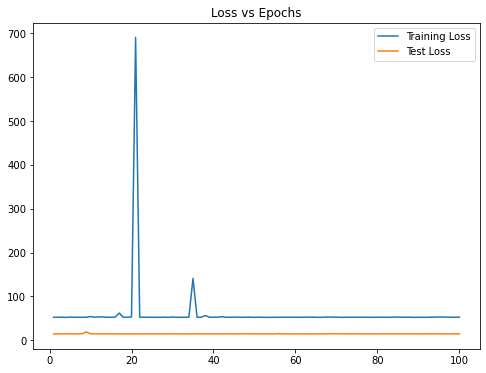

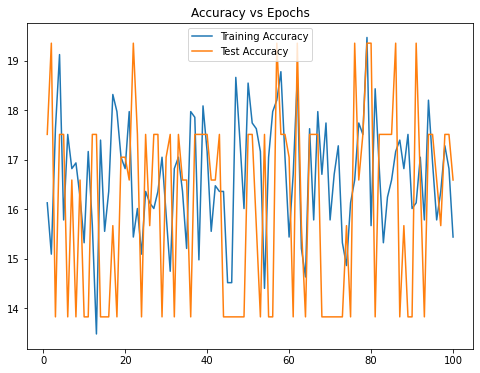

In [27]:
_epochs = [i for i in range(1, EPOCHS+1)]

plt.figure(figsize = (8,6))
plt.plot(_epochs, train_losses, label = "Training Loss")
plt.plot(_epochs, test_losses, label = "Test Loss")
plt.title("Loss vs Epochs", fontsize=12)
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(_epochs, train_accs, label = "Training Accuracy")
plt.plot(_epochs, test_accs, label = "Test Accuracy")
plt.title("Accuracy vs Epochs", fontsize=12)
plt.legend()
plt.show()

# ViT


In [30]:
dataset = AudioDataset(audio_paths, LABEL_TYPE, LABEL_ENCODING)
dataset_size = len(dataset)

split = 0.2 # Train-Test split is 80% 20%
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

batch_size = 30
# Shape should be BATCH, 1 (Mono Channel), N_MELS, TIME_BINS -> torch.Size([8, 1, 64, 1379])
train_loader = DataLoader(train_set, 
                          shuffle = True, 
                          batch_size = batch_size)
test_loader = DataLoader(test_set, 
                        shuffle = True, 
                        batch_size = batch_size)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 88200
# model = ViT(
#     image_size = (64, 1379),
#     patch_size = (32, 197),
#     num_classes = 6,
#     dim = 1024,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1,
#     channels = 1
# ).to(device)

#44100
model = ViT(
    image_size = (64, 690),
    patch_size = (32, 30),
    num_classes = 6,
    dim = 1024,
    depth = 4,
    heads = 16,
    mlp_dim = 1024,
    dropout = 0.01,
    emb_dropout = 0.01,
    channels = 1
).to(device)

learning_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=5,  
                                            gamma=0.5)

In [33]:
EPOCHS = 100

train_losses = []
train_accs = []

test_losses = []
test_accs = []

print("ViT")
start = time.time()

for epoch in range(1, EPOCHS+1):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader):
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)
        predictions = model(features)

        loss = criterion(predictions,labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        train_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    with torch.no_grad():
      test_loss = 0.0 
      test_acc = 0.0
      for i, data in enumerate(test_loader):
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)
        predictions = model(features)

        loss = criterion(predictions, labels)
        test_loss += loss.item()

        test_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc = 100*train_acc.item()/len(train_set)
    test_acc = 100*test_acc.item()/len(test_set)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch: {epoch} Train Loss: {round(train_loss,4)} Test Loss: {round(test_loss,4)} Train Acc: {round(train_acc,4)}% Test Acc: {round(test_acc,4)}%")
    
print(f"Done training after {time.time()-start} seconds")

ViT
Epoch: 1 Train Loss: 93.4923 Test Loss: 14.674 Train Acc: 19.47% Test Acc: 19.8157%
Epoch: 2 Train Loss: 52.3405 Test Loss: 14.3186 Train Acc: 20.6221% Test Acc: 20.7373%
Epoch: 3 Train Loss: 51.7265 Test Loss: 14.3723 Train Acc: 21.7742% Test Acc: 20.7373%
Epoch: 4 Train Loss: 51.7288 Test Loss: 14.2404 Train Acc: 22.5806% Test Acc: 21.659%
Epoch: 5 Train Loss: 51.7787 Test Loss: 14.328 Train Acc: 22.1198% Test Acc: 21.1982%
Epoch: 6 Train Loss: 51.7542 Test Loss: 14.3412 Train Acc: 23.2719% Test Acc: 21.1982%
Epoch: 7 Train Loss: 51.7095 Test Loss: 14.3321 Train Acc: 22.235% Test Acc: 19.8157%
Epoch: 8 Train Loss: 51.7219 Test Loss: 14.3231 Train Acc: 22.235% Test Acc: 20.7373%
Epoch: 9 Train Loss: 51.7503 Test Loss: 14.3412 Train Acc: 22.0046% Test Acc: 19.8157%
Epoch: 10 Train Loss: 51.7523 Test Loss: 14.381 Train Acc: 22.4654% Test Acc: 19.3548%
Epoch: 11 Train Loss: 51.7473 Test Loss: 14.335 Train Acc: 21.4286% Test Acc: 21.1982%
Epoch: 12 Train Loss: 51.7709 Test Loss: 14.31

In [34]:
x, y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)

In [35]:
model.eval()
(torch.argmax(model(x), dim=1) == y).float().mean()

tensor(0.2000, device='cuda:0')

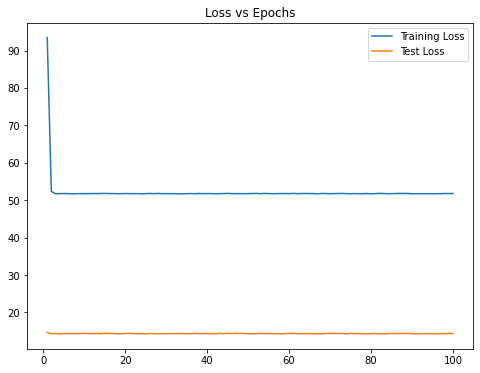

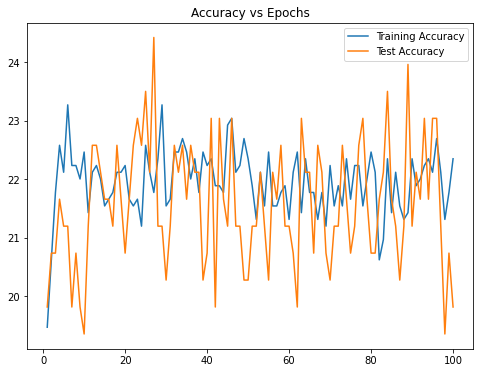

In [36]:
_epochs = [i for i in range(1, EPOCHS+1)]

plt.figure(figsize = (8,6))
plt.plot(_epochs, train_losses, label = "Training Loss")
plt.plot(_epochs, test_losses, label = "Test Loss")
plt.title("Loss vs Epochs", fontsize=12)
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(_epochs, train_accs, label = "Training Accuracy")
plt.plot(_epochs, test_accs, label = "Test Accuracy")
plt.title("Accuracy vs Epochs", fontsize=12)
plt.legend()
plt.show()

In [ ]:
conformer = torchaudio.models.Conformer(
     input_dim=80,
    num_heads=4,
    ffn_dim=128,
         num_layers=4,
   depthwise_conv_kernel_size=31,
)
lengths = torch.randint(1, 400, (10,))  # (batch,)
input = torch.rand(10, int(lengths.max()), 80)  # (batch, num_frames, input_dim)
output = conformer(input, lengths)

In [ ]:
input.size()

torch.Size([10, 384, 80])

In [ ]:
dir(torchaudio.pipelines)

['EMFORMER_RNNT_BASE_LIBRISPEECH',
 'HUBERT_ASR_LARGE',
 'HUBERT_ASR_XLARGE',
 'HUBERT_BASE',
 'HUBERT_LARGE',
 'HUBERT_XLARGE',
 'RNNTBundle',
 'TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH',
 'TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH',
 'TACOTRON2_WAVERNN_CHAR_LJSPEECH',
 'TACOTRON2_WAVERNN_PHONE_LJSPEECH',
 'Tacotron2TTSBundle',
 'VOXPOPULI_ASR_BASE_10K_DE',
 'VOXPOPULI_ASR_BASE_10K_EN',
 'VOXPOPULI_ASR_BASE_10K_ES',
 'VOXPOPULI_ASR_BASE_10K_FR',
 'VOXPOPULI_ASR_BASE_10K_IT',
 'WAV2VEC2_ASR_BASE_100H',
 'WAV2VEC2_ASR_BASE_10M',
 'WAV2VEC2_ASR_BASE_960H',
 'WAV2VEC2_ASR_LARGE_100H',
 'WAV2VEC2_ASR_LARGE_10M',
 'WAV2VEC2_ASR_LARGE_960H',
 'WAV2VEC2_ASR_LARGE_LV60K_100H',
 'WAV2VEC2_ASR_LARGE_LV60K_10M',
 'WAV2VEC2_ASR_LARGE_LV60K_960H',
 'WAV2VEC2_BASE',
 'WAV2VEC2_LARGE',
 'WAV2VEC2_LARGE_LV60K',
 'WAV2VEC2_XLSR53',
 'Wav2Vec2ASRBundle',
 'Wav2Vec2Bundle',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_tt

In [ ]:
dir(torchaudio.models)

['Conformer',
 'ConvTasNet',
 'DeepSpeech',
 'Emformer',
 'HuBERTPretrainModel',
 'Hypothesis',
 'RNNT',
 'RNNTBeamSearch',
 'Tacotron2',
 'Wav2Letter',
 'Wav2Vec2Model',
 'WaveRNN',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'conformer',
 'conv_tasnet',
 'deepspeech',
 'emformer',
 'emformer_rnnt_base',
 'emformer_rnnt_model',
 'hubert_base',
 'hubert_large',
 'hubert_pretrain_base',
 'hubert_pretrain_large',
 'hubert_pretrain_model',
 'hubert_pretrain_xlarge',
 'hubert_xlarge',
 'rnnt',
 'rnnt_decoder',
 'tacotron2',
 'wav2letter',
 'wav2vec2',
 'wav2vec2_base',
 'wav2vec2_large',
 'wav2vec2_large_lv60k',
 'wav2vec2_model',
 'wavernn']

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())


Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


# Using HuggingFace

In [7]:
audio_classes = []

for count, i in enumerate(audio_paths):
  if count % 100 == 0:
    print(count)
  audio_classes.append(Audio(i, LABEL_TYPE, LABEL_ENCODING))

0
100
200
300
400
500
600
700
800
900
1000


In [8]:
audio_arrays = []
labels_arrays = []
for i in audio_classes:
  audio_padded = i.pad_time_series(i.get_audio(), 44100)
  audio_resampled = i.resample(audio_padded, i.sr, 16000)
  a,b = i.get_time_series_and_label(audio_resampled)
  audio_arrays.append(a.numpy())
  labels_arrays.append(b)

In [9]:
from datasets import Dataset as HFDataset, DatasetDict, load_metric
from sklearn.model_selection import train_test_split
from transformers import AutoFeatureExtractor

model_checkpoint = "facebook/wav2vec2-base"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

X_train, X_test, y_train, y_test = train_test_split(audio_arrays, labels_arrays, test_size=0.2, random_state=42)

train_dict = {"audio": np.array(X_train), "label": np.array(y_train)}
test_dict = {"audio": np.array(X_test), "label": np.array(y_test)}

train_dataset = HFDataset.from_dict(train_dict)
test_dataset = HFDataset.from_dict(test_dict)


dataset = DatasetDict({"train": train_dataset, "test":test_dataset})
metric = load_metric("accuracy")
dataset

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/transformers/configuration_utils.py:359: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 868
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 217
    })
})

In [10]:
def preprocess_function(examples):
  audio_arrays = [i for i in examples["audio"]]
  inputs = feature_extractor(
      audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000, truncation=True
  )
  return inputs

In [11]:
preprocess_function(dataset["train"][:2])["input_values"]

[array([-0.01362541, -0.01807866,  0.0037419 , ...,  1.0655563 ,
         2.040346  ,  2.21717   ], dtype=float32),
 array([0.00037692, 0.00037692, 0.00037692, ..., 0.00037692, 0.00037692,
        0.00037692], dtype=float32)]

In [12]:
encoded_dataset = dataset.map(preprocess_function, remove_columns=["audio"], batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [13]:
preprocess_function(dataset['train'][:2])["input_values"]

[array([-0.01362541, -0.01807866,  0.0037419 , ...,  1.0655563 ,
         2.040346  ,  2.21717   ], dtype=float32),
 array([0.00037692, 0.00037692, 0.00037692, ..., 0.00037692, 0.00037692,
        0.00037692], dtype=float32)]

In [14]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

label2id = LABEL_ENCODING
id2label = dict((v,k) for k,v in label2id.items())
num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint, num_labels=num_labels, label2id=label2id, id2label=id2label
)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['quantizer.weight_proj.weight', 'quantizer.codevectors', 'project_hid.weight', 'quantizer.weight_proj.bias', 'project_q.bias', 'project_q.weight', 'project_hid.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['projector.weight', 'projector.bias', 'classifier.

In [15]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [20]:
 time.strftime("%Y-%m-%d_%H-%M-%S")

'2022-05-02_04-09-37'

In [33]:
batch_size = 40
EPOCHS = 20
output_dir = "./hf_models/"
output_dir = os.path.join(output_dir, time.strftime("%Y-%m-%d_%H-%M-%S"))

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=4,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [34]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

In [35]:
%%time
trainer.train()


***** Running training *****
  Num examples = 868
  Num Epochs = 20
  Instantaneous batch size per device = 40
  Total train batch size (w. parallel, distributed & accumulation) = 160
  Gradient Accumulation steps = 4
  Total optimization steps = 100


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,1.721785,0.313364
1,1.770000,1.705821,0.281106
2,1.770000,1.698535,0.290323
3,1.768800,1.570393,0.474654
4,1.768800,1.566364,0.483871
5,1.676500,1.526254,0.488479
6,1.676500,1.514710,0.433180
7,1.587300,1.513682,0.451613
8,1.587300,1.486805,0.456221
9,1.490600,1.473328,0.460829


***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
Saving model checkpoint to ./hf_models/2022-05-02_04-12-42/checkpoint-5
Configuration saved in ./hf_models/2022-05-02_04-12-42/checkpoint-5/config.json
Model weights saved in ./hf_models/2022-05-02_04-12-42/checkpoint-5/pytorch_model.bin
Feature extractor saved in ./hf_models/2022-05-02_04-12-42/checkpoint-5/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
Saving model checkpoint to ./hf_models/2022-05-02_04-12-42/checkpoint-10
Configuration saved in ./hf_models/2022-05-02_04-12-42/checkpoint-10/config.json
Model weights saved in ./hf_models/2022-05-02_04-12-42/checkpoint-10/pytorch_model.bin
Feature extractor saved in ./hf_models/2022-05-02_04-12-42/checkpoint-10/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
Saving model checkpoint to ./hf_models/2022-05-02_04-12-42/checkpoint-15
Configuration saved in ./hf_models/2022-05-

TrainOutput(global_step=100, training_loss=1.4844055557250977, metrics={'train_runtime': 1115.0914, 'train_samples_per_second': 15.568, 'train_steps_per_second': 0.09, 'total_flos': 1.56989422123776e+17, 'train_loss': 1.4844055557250977, 'epoch': 19.91})

In [36]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 217
  Batch size = 40


{'eval_loss': 1.4311763048171997,
 'eval_accuracy': 0.5023041474654378,
 'eval_runtime': 3.7473,
 'eval_samples_per_second': 57.908,
 'eval_steps_per_second': 1.601,
 'epoch': 19.91}

In [ ]:
a